In [2]:
import numpy as np
import flopy
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import csv
import time
import seaborn as sns
sns.set_style("white")

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm

from flopy.utils.sfroutputfile import SfrFile

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

from treeFuncs import trainAndEvaluateModel 
from treeFuncs import metrics
from treeFuncs import plotImportance

modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws= "D:/mfoutput"

C:\Users\davem\anaconda3\lib\site-packages\spotpy\algorithms\padds.py:5: DeprecationWarning: Please use `ConvexHull` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, QhullError
C:\Users\davem\anaconda3\lib\site-packages\spotpy\algorithms\padds.py:5: DeprecationWarning: Please use `QhullError` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import ConvexHull, QhullError


In [3]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio','Pumping Rate','Qout']
col_dict = {'K':'Base K', 'Low_K_ratio': 'Confining Layer K (as a ratio to Base K)', 'Sy':'Specific Yield', 'Rech':'Recharge', 'ET_valley':'Valley ET', 'ET_rip_ratio':'Riparian ET (as a Ratio of Valley ET)', 'Stream_K_ratio':'Streambed K', 'Pumping Rate':'Pumping Well Discharge Factor'}
#col_names = col_dict.keys
# load dataset
#data_old = np.loadtxt("outputs/ModflowSfrWellOutput750Test3.txt")
#data = np.loadtxt("mf_notebooks/ModflowSfrWellOutput750Test5.txt")
data = np.loadtxt("mf_notebooks/ModflowSfrWellOutput1000Test7.txt")

#data = np.loadtxt("ModflowSfrOutput2500New.txt")
error_list = np.loadtxt("mf_notebooks/ErrorSS_SfrWell1000Test7.txt")
eidx = np.array(error_list)[:,0].astype(int)
# #print(eidx)
temprange = np.arange(1000)

error_free = np.delete(temprange, eidx, axis=0)

df = pd.DataFrame(data, index=error_free, columns = col_names)

print(df.index.shape) #how big is it 

#Set inputs and targets

X = df[col_names[:-1]] 
Y = df[col_names[-1]] #the last column in the saved csv is the flow at reach 49 - this is for ease of testing - other reaches are brought in later 

   

(944,)


C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1036: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = self.plt.cm.get_cmap(cmap)
C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1036: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = self.plt.cm.get_cmap(cmap)


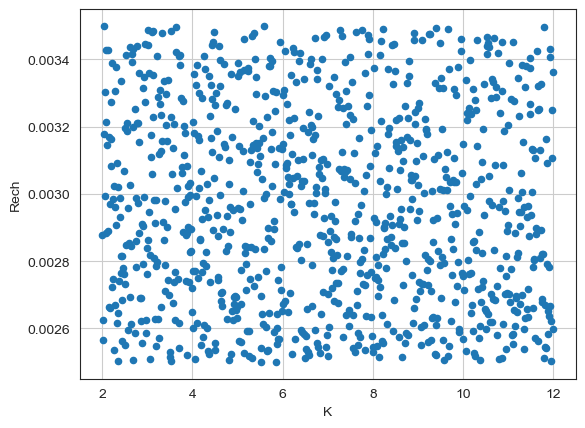

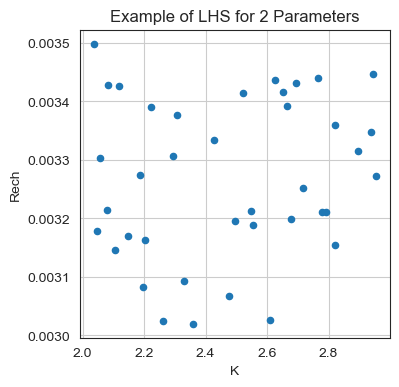

In [4]:
df.plot(kind='scatter',x ='K',y='Rech',grid = True)
sampledf = df[(df['K'] < 3) & (df['K'] > 1) & (df['Rech'] < .004) & (df['Rech'] > .003)]

sampledf.plot(kind='scatter',x ='K',y='Rech',grid = True, figsize=(4,4))
plt.title('Example of LHS for 2 Parameters')
plt.show()

In [183]:
#Save reach flow output as pkl
#ReachQdf.to_pickle('outputs/SS_reachQ.pkl')

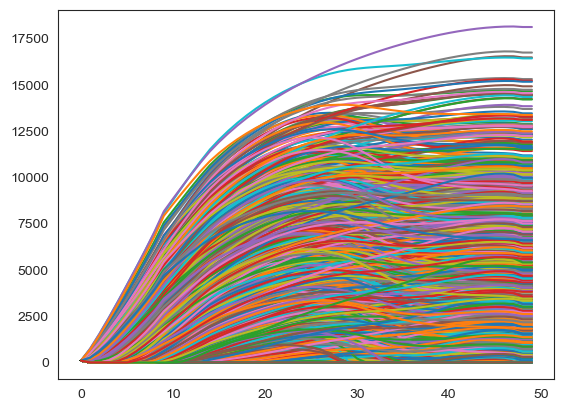

In [6]:
error_list = np.loadtxt("mf_notebooks/ErrorSS_SfrWell1000Test7.txt")
eidx = np.array(error_list)[:,0].astype(int)
# #print(eidx)
temprange = np.arange(1000)
error_free = np.delete(temprange, eidx, axis=0)

# error_list2 = np.loadtxt("outputs/ErrorSS_SfrWell750Test3.txt") #used the error free simulations from test 3 in test 5 so have to bring those in again to remove them to create the error list
# #eidx2 = np.array(error_list2)[:,0].astype(int)
# temprange2 = np.arange(750-len(error_list2))
# #error_free = temprange[eidx]
# error_free = temprange2#np.delete(temprange2, eidx, axis=0)

if eidx.shape[0] == 0:
    error_free = temprange #if no errors

#Sey up arrays to store reach data and budget data
ReachAqf = np.ndarray((len(error_free),50))
#ReachAqf = np.ndarray((100,50)) #for testing CMS
depth = np.ndarray((len(error_free),50))
width = np.ndarray((len(error_free),50))
q = np.ndarray((len(error_free),50))


#Should change this to be multi-level index - one day
for j,i in enumerate(df.index.values):
#for j,i in enumerate(range(100)): #for testing CMS
    modelname = "/ScenarioSfrWell1000Test7"+str(i)
    sfrout = SfrFile(modws+'\\'+modelname+'.sfr.out')
    Sfrdf = sfrout.get_dataframe() 
   # print(Sfrdf.columns)
    ReachAqf[j] = Sfrdf.Qaquifer
    depth[j] = Sfrdf.depth
    width[j] = Sfrdf.width
    q[j] = Sfrdf.Qout[:]
    plt.plot(Sfrdf.Qout[:])
#plt.yscale('log')    

Text(65.34722222222221, 0.5, 'Discharge (cmd)')

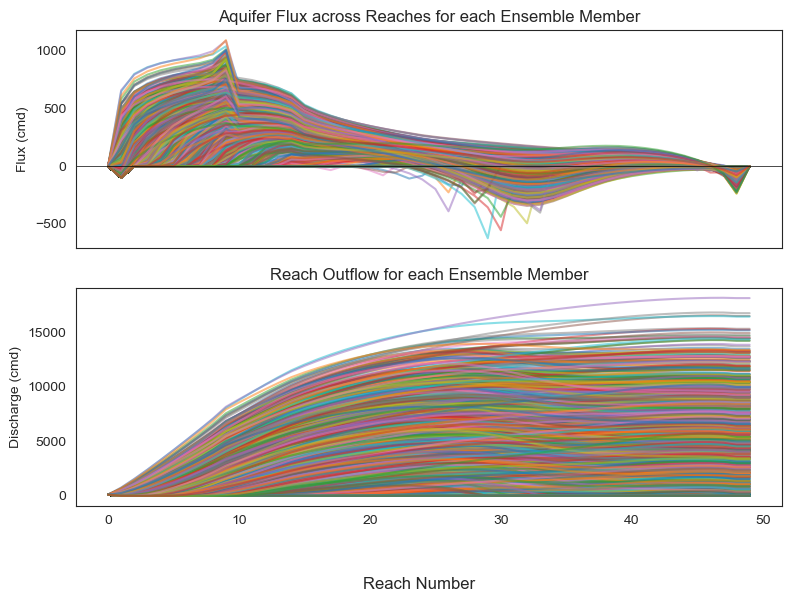

In [12]:
ReachAqfdf = pd.DataFrame(ReachAqf).fillna(0)
depthdf = pd.DataFrame(depth)#.fillna(0)
velocity = np.nan_to_num(q/(depth * width) / 86400) #converting to m/s
vel_df = pd.DataFrame(velocity).fillna(0)
width_df = pd.DataFrame(width).fillna(0)
q_df =pd.DataFrame(q, index = error_free).fillna(0) 
#ReachAqfdf = ReachAqfdf.loc[ReachQdf.index]
#display(ReachAqfdf)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=False,figsize=(8, 6))
#fig.suptitle('Variations in Aquifer Discharge and Stream Reach Outflow across Stream Reaches ')
#fig.supylabel('Discharge (cmd) - Log Scale')
fig.supxlabel('Reach Number')
fig.tight_layout(pad = 2)

for i in ReachAqfdf.index:  
#for i in range(100):
    axs[0].plot(ReachAqfdf.loc[i]*-1, alpha = 0.5) 
    axs[1].plot(q_df.iloc[i], alpha = 0.5)
#     axs[2].plot(vel_df.loc[i], alpha = 0.5)
#     axs[3].plot(depthdf.loc[i], alpha = 0.5)

axs[0].title.set_text('Aquifer Flux across Reaches for each Ensemble Member')
axs[0].set_ylabel('Flux (cmd)')
#axs[2].set_ylim((0,5))
#axs[3].set_ylim((0,20))
axs[0].axhline(0, color='black', linewidth=.5)

axs[1].title.set_text('Reach Outflow for each Ensemble Member')
axs[1].set_ylabel('Discharge (cmd)')
# axs[2].title.set_text('Velocity across All 50 Reaches for All Simulations')
# axs[2].set_ylabel('Velocity (m/s)')
# axs[3].title.set_text('Depth across All 50 Reaches for All Simulations')
# axs[4].set_ylabel('Depth (m)')


In [77]:
#q_df.to_pickle('outputs/SS_reachQ1000_test11.pkl')

23
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=944)
Int64Index([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,
            ...
            989, 990, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=823)
(823, 50)


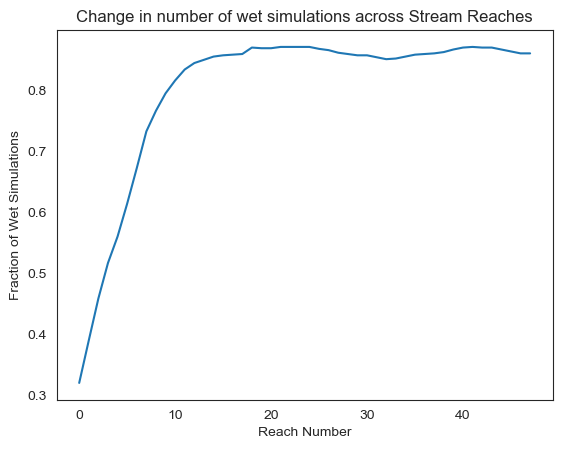

In [13]:
#Getting rid of ensembles with 0 flow
#ReachQdf = pd.read_pickle('outputs/SS_reachQ.pkl')
#ReachQdf = pd.read_pickle('outputs/SS_reachQ_test5.pkl')
ReachQdf = pd.read_pickle('outputs/SS_reachQ1000_test7.pkl')


#ReachQdf = pd.DataFrame(ReachQ)

numgrz = [len(ReachQdf[i][ReachQdf[i] > 0].index)/len(ReachQdf.index) for i in range(50)] 
print(numgrz.index(max(numgrz[2:])))


#plt.figure(figsize=(11,3))
plt.plot(numgrz[2:])
    
#plt.ylim((0.01,np.max(ReachQdf)+10))
plt.ylabel('Fraction of Wet Simulations')
plt.xlabel('Reach Number')
plt.title('Change in number of wet simulations across Stream Reaches')
plt.margins(0.05)

print(ReachQdf.index)

rn_highest = numgrz.index(max(numgrz[2:])) #find reach with greatest number of wet ensembles 
ReachQdf = ReachQdf[ReachQdf[rn_highest] > 0]
print(ReachQdf.index)
print(ReachQdf.shape)

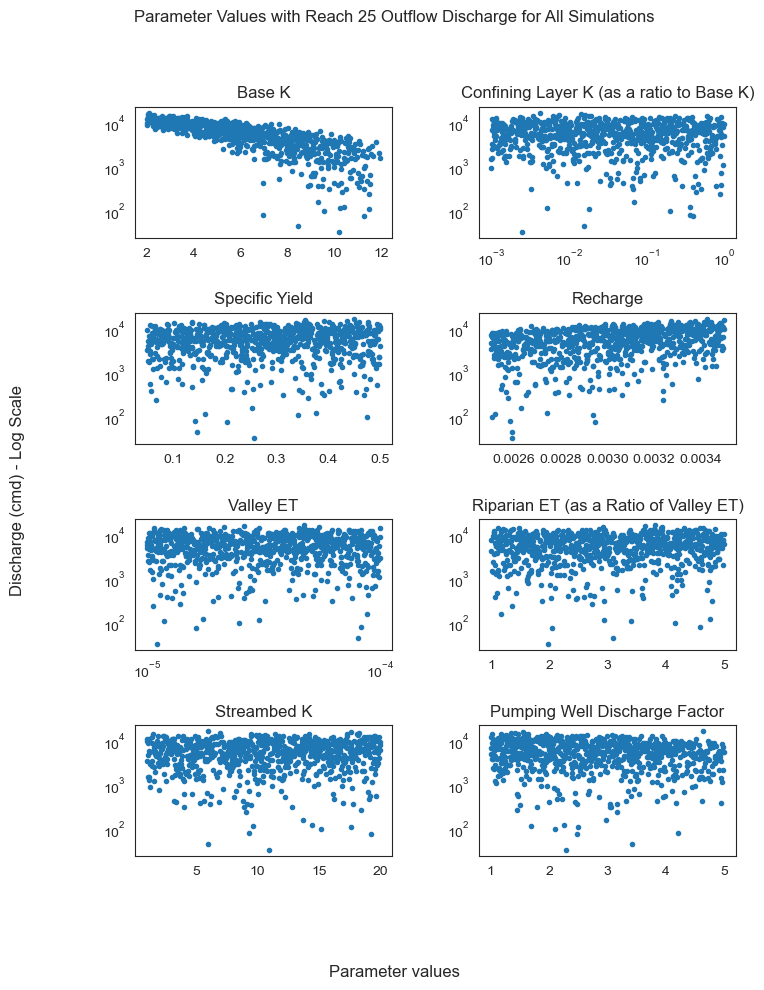

In [17]:
#Plot out the parameters per ensemble discharge at reach 25

#Uncomment line below if pulling from pkl file
#ReachQdf = pd.read_pickle('outputs/SS_reachQ.pkl')

#print(X.index, ReachQdf.index)
params = X.loc[ReachQdf.index]


fig, axs = plt.subplots(4, 2, sharex=False, sharey=False,figsize=(8, 10))
fig.suptitle('Parameter Values with Reach 25 Outflow Discharge for All Simulations')
fig.supylabel('Discharge (cmd) - Log Scale')
fig.supxlabel('Parameter values')
fig.tight_layout(pad = 3.5)
#fig.delaxes(axs[3,1])
# for i in range(len(col_names) - 1):
#     axs.plot(X[col_names[i]],Y,'k.')
i=0
logpars = [1,4]
for row in axs:
    for col in row: 
        col.plot(params[col_names[i]],ReachQdf[32],'.')
        col.title.set_text(col_dict[col_names[i]])
        if i in logpars:
            col.set_xscale('log')
        col.set_yscale('log')
        if i < (len(col_names)-2):
            i+=1
        else:
            break

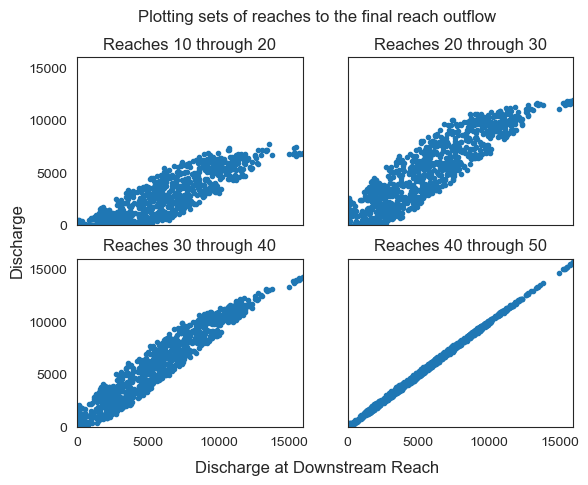

Text(0.5, 0, 'Reach Number')

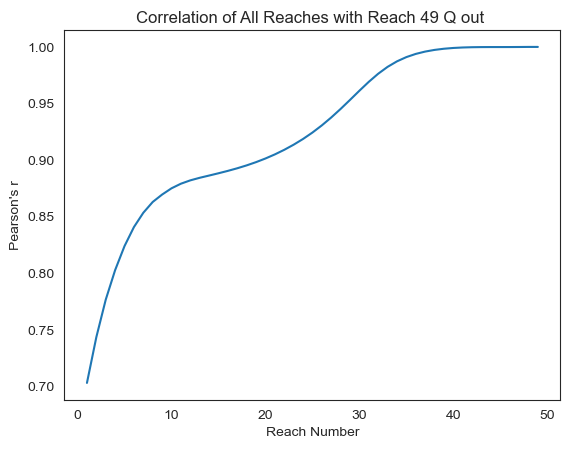

In [10]:
## PLotting out Correlations of reach flows
##examine flows for every reach compared to ds most reach (49)

#print(ReachQdf.head())
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('Plotting sets of reaches to the final reach outflow')
fig.supylabel('Discharge')
fig.supxlabel('Discharge at Downstream Reach')

k=10
for row in axs:
    for col in row:        
        for i in range(k,k+10,10):
            col.plot(ReachQdf[49],ReachQdf[i], '.')
            col.title.set_text('Reaches ' +str(k) +' through ' +str(k+10))
        k+=10

plt.xlim(0,int(ReachQdf[49].max()))
plt.ylim(0,int(ReachQdf[49].max()))
plt.show()

    
ReachQdf.corrwith(ReachQdf[49]).plot()
plt.title('Correlation of All Reaches with Reach 49 Q out ')
plt.ylabel('Pearson\'s r')
plt.xlabel('Reach Number')

## Now for the Modflow Cell Heads

In [15]:
#load in Ibound and find active cells in model - then put it into a list of well locations

ibound = np.loadtxt('base/ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T
print(all_well_loc) #nrow,ncol

[[ 1  5]
 [ 1  6]
 [ 1  7]
 ...
 [48 16]
 [48 17]
 [48 18]]


In [82]:
#Get Head data for All active wells

# temprange = np.arange(750)

error_list = np.loadtxt("mf_notebooks/ErrorSS_SfrWell1000Test7.txt")
eidx = np.array(error_list)[:,0].astype(int)
#print(eidx)
temprange = np.arange(1000)



# error_list2 = np.loadtxt("outputs/ErrorSS_SfrWell750Test3.txt") #used the error free simulations from test 3 in test 5 so have to bring those in again to remove them to create the error list
# #eidx2 = np.array(error_list2)[:,0].astype(int)
# temprange2 = np.arange(750-len(error_list2))
# #error_free = temprange[eidx]

error_free = np.delete(temprange, eidx, axis=0)

error_free = ReachQdf.index.values

well_head = np.empty((len(error_free),all_well_loc.shape[0]))
well_error_sim = []
#well_error_num = []
for j, i in enumerate(error_free):
#for j, i in enumerate(df_flow.index):
    modelname = "ScenarioSfrWell1000Test7_"+str(i)
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
    head = headobj.get_alldata(nodata=0)#-9.9998999e+02)
    
    for k in range(all_well_loc.shape[0]):        
        well_head[j][k] = head[0][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])]        #ntime, nlay, nrow, ncol
        #if (well_head[k][j] < 0) or (well_head[k][j] > 200) or np.isnan(well_head[k][j]):
        if (well_head[j][k] > 120 or np.isnan(well_head[j][k]) or well_head[j][k] < 0):
            well_error_sim.append(i)
            

well_head_df = pd.DataFrame(well_head, index = ReachQdf.index)

new_zone = ReachQdf.loc[~ReachQdf.index.isin(np.unique(well_error_sim))]
well_head_df = well_head_df.loc[new_zone.index]

print(len(well_head_df.index))

well_head_df.to_pickle('outputs/heads/WellHead_SS1000test7.pkl')


957


In [16]:
#well_head_df.to_pickle('outputs/heads/WellHead_SS_test4.pkl')

#if not pulling new heads
#well_head_df = pd.read_pickle('outputs/heads/WellHead_SS.pkl')
#well_head_df= pd.read_pickle('outputs/heads/WellHead_SStest5.pkl')
well_head_df= pd.read_pickle('outputs/heads/WellHead_SS1000test7.pkl')

#well_head_df= pd.read_pickle('WellHead_SStest5.pkl')

print(well_head_df.index)
print(ReachQdf.index)
#use only simulations that are similar to ReachQdf - or in this case > 0 at reach 25
#well_head_df = well_head_df.loc[ReachQdf.index]

ReachQdf = ReachQdf.loc[well_head_df.index]


Int64Index([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,
            ...
            989, 990, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=800)
Int64Index([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,
            ...
            989, 990, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=823)


In [59]:
#Pulling head values for runs without pumping
#using the pumping simulations df index to match 
members = np.loadtxt("mf_notebooks/ModflowSfrWellOutput1000Test7NoPumping.txt")
well_head = np.empty((len(members),all_well_loc.shape[0]))

for j, i in enumerate(members):
#for j, i in enumerate(df_flow.index):
    modelname = "ScenarioSfrWell1000Test7NoPumping_"+str(int(i))
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
    head = headobj.get_alldata(nodata=0)#-9.9998999e+02)
    
    for k in range(all_well_loc.shape[0]):        
        well_head[j][k] = head[0][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])]        #ntime, nlay, nrow, ncol

No_pumping_well_head_df = pd.DataFrame(well_head, index = members)

#save to pickle
No_pumping_well_head_df.to_pickle('outputs/heads/WellHead_SS1000test10NoPumping.pkl')


In [60]:
#Should change this to be multi-level index - one day
NoPumpQ = np.ndarray((len(members),50))
for j,i in enumerate(members):
    modelname = "/ScenarioSfrWell1000Test10NoPumping_"+str(int(i))
    sfrout = SfrFile(modws+'\\'+modelname+'.sfr.out')
    Sfrdf = sfrout.get_dataframe() 
    NoPumpQ[j] = Sfrdf.Qout[:]
    
NoPumpingReachQ = pd.DataFrame(NoPumpQ, index = members)

NoPumpingReachQ.to_pickle('outputs/SS_reachQ1000_test10NoPumping.pkl')
#plt.yscale('log') 

,0,1,2,3,4,5,6,7,8,9,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
0.0,0.575035,0.581108,0.590836,0.602402,0.616043,0.627922,0.642250,0.658684,0.676949,0.696747,...,0.115181,0.114044,0.112793,0.111458,0.110077,0.108688,0.107346,0.106026,0.104843,0.103973
1.0,2.250832,2.283539,2.336288,2.399879,2.474960,2.540863,2.620895,2.712692,2.814934,2.926727,...,0.250343,0.254616,0.259796,0.265678,0.272156,0.279144,0.286659,0.293884,0.300476,0.305351
2.0,1.387527,1.408226,1.441544,1.481567,1.528786,1.569595,1.618248,1.674065,1.736176,1.803757,...,0.047920,0.048698,0.049614,0.050652,0.051804,0.053047,0.054352,0.055626,0.056808,0.057686
4.0,1.435738,1.456978,1.491257,1.532730,1.581741,1.625641,1.677841,1.737602,1.804169,1.876816,...,0.060028,0.061066,0.062294,0.063683,0.065208,0.066864,0.068626,0.070335,0.071907,0.073067
6.0,1.306519,1.324623,1.353676,1.388397,1.429214,1.462021,1.503479,1.551872,1.606270,1.666069,...,0.241707,0.245514,0.250366,0.256004,0.262299,0.269157,0.276535,0.283669,0.290138,0.294907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993.0,1.208244,1.225136,1.252327,1.285027,1.323402,1.351364,1.387939,1.431686,1.481834,1.538002,...,0.275452,0.279861,0.285698,0.292664,0.300606,0.309441,0.319122,0.328453,0.336884,0.343071
994.0,0.501221,0.506737,0.515572,0.526062,0.538406,0.548172,0.560593,0.575157,0.591553,0.609543,...,0.148094,0.148560,0.149338,0.150352,0.151566,0.152985,0.154594,0.156143,0.157547,0.158585
996.0,2.501572,2.536835,2.593620,2.661888,2.742020,2.798088,2.872482,2.962204,3.065796,3.182487,...,0.619347,0.628975,0.641853,0.657356,0.675133,0.695000,0.716843,0.737923,0.757011,0.771011
997.0,0.857117,0.867226,0.883408,0.902664,0.925354,0.945099,0.969139,0.996635,1.027107,1.060120,...,0.197281,0.198105,0.199226,0.200577,0.202110,0.203842,0.205757,0.207603,0.209305,0.210564


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0.0,0.0,0.000,0.000,0.00,0.00,0.000,0.00,0.00,0.00,0.000,...,4233.42,4317.97,4387.51,4443.7,4487.36,4518.91,4538.18,4543.35,4523.97,4523.97
1.0,0.0,54.110,108.410,163.50,219.60,277.300,337.10,399.70,466.00,537.200,...,7393.60,7547.90,7675.80,7782.2,7867.40,7932.80,7979.80,8009.50,8018.60,8018.60
2.0,0.0,37.546,74.810,112.59,151.00,190.300,230.80,272.80,316.50,362.200,...,6323.10,6449.30,6553.90,6638.4,6707.10,6758.90,6795.70,6816.40,6816.40,6816.40
4.0,0.0,31.610,63.300,95.30,127.80,161.300,195.60,231.20,268.20,306.900,...,4968.00,5068.00,5152.00,5220.0,5275.00,5317.00,5346.00,5365.00,5369.00,5369.00
6.0,0.0,0.000,30.844,125.34,198.19,267.530,337.50,411.00,491.50,586.400,...,6370.80,6502.60,6613.90,6705.1,6779.30,6835.70,6875.90,6900.80,6905.20,6905.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993.0,0.0,31.180,62.470,94.40,127.20,161.500,197.70,237.10,282.00,338.600,...,2928.10,2989.80,3041.00,3084.1,3119.30,3147.10,3167.10,3179.80,3184.20,3184.20
994.0,0.0,0.000,0.000,0.00,0.00,0.000,0.00,0.00,0.00,131.939,...,2751.40,2809.30,2858.00,2898.3,2930.50,2955.20,2972.40,2982.20,2981.10,2981.10
996.0,0.0,63.160,126.570,191.20,257.80,327.400,401.30,481.60,573.40,690.800,...,5626.20,5744.70,5845.20,5929.4,5997.00,6050.70,6090.20,6115.60,6124.30,6124.30
997.0,0.0,0.000,0.000,0.00,0.00,0.000,0.00,109.63,215.68,311.370,...,6176.70,6306.00,6414.30,6503.1,6573.80,6627.10,6663.50,6682.50,6681.00,6681.00


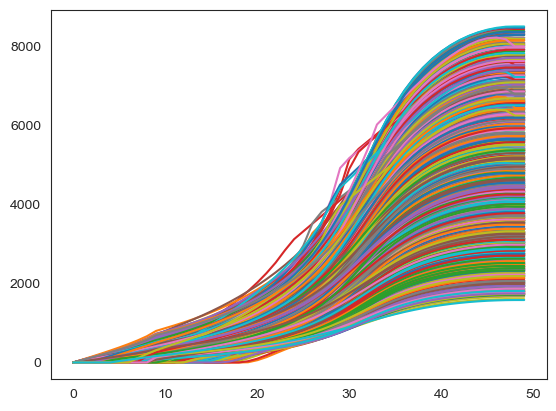

In [80]:
#Calcualting the difference in heads from the wells and in the flows from with the well and without
NoPumpingReachQ = pd.read_pickle('outputs/SS_reachQ1000_test7NoPumping.pkl')
No_pumping_well_head_df = pd.read_pickle('outputs/heads/WellHead_SS1000test7NoPumping.pkl')
members = np.loadtxt("mf_notebooks/ModflowSfrWellOutput1000Test7NoPumping.txt")

diff_head_df = No_pumping_well_head_df - well_head_df.loc[members.astype('int')]
diff_reachq_df = NoPumpingReachQ - ReachQdf.loc[members.astype('int')]

#diff_head_df = diff_head_df.round(0)
display(diff_head_df)
display(diff_reachq_df)
for i in members:
    diff_reachq_df.loc[i].plot()

## Using Heads to predict stream Flow

In [81]:
## Setting up the head inputs - dropping out the downstream most CH boundary and the river cells 

river_well_loc = np.where(all_well_loc[:,0] == 25)
#river_well_loc = np.where((all_well_loc[:,0] > 23) & (all_well_loc[:,0] < 27))

CHBound_loc = np.where(all_well_loc[:,1] > 47)
RechBound_loc = np.where(all_well_loc[:,1] < 10) #
upperRows = np.where(all_well_loc[:,0] > 35)
lowerRows = np.where(all_well_loc[:,0] < 15)
drop_locs= np.concatenate((CHBound_loc,upperRows,lowerRows,RechBound_loc), axis = 1)

#drop_locs= np.concatenate((river_well_loc, CHBound_loc,upperRows,lowerRows,RechBound_loc), axis = 1)
drop_locs= np.concatenate((river_well_loc, CHBound_loc), axis = 1)
#drop_locs= np.concatenate((river_well_loc, CHBound_loc, RechBound_loc), axis = 1)


#For testing out all the cells
drop_locs = [[]]

well_head_noRiv = well_head_df.drop(drop_locs[0], axis = 1)
new_zone_q = ReachQdf.loc[well_head_noRiv.index]

#Below for diff dfs
well_head_noRiv = diff_head_df.drop(drop_locs[0], axis = 1)
new_zone_q = diff_reachq_df.loc[well_head_noRiv.index]

well_head_noRiv.columns = well_head_noRiv.columns.astype(str)

well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])
print(well_head_noRiv.shape)


#Normalizing inputs (?) - not currently using 
# norm_well_df = (well_head_noRiv - np.min(well_head_noRiv.min().values))
# norm_well_df = norm_well_df / np.max(well_head_noRiv.max().values)
# norm_well_df.columns = norm_well_df.columns.astype(str)

# norm_q_df = (new_zone_q - np.min(new_zone_q.min().values))
# norm_q_df = norm_q_df/ np.max(new_zone_q.max().values)

# display(well_head_noRiv)
# display(norm_well_df)
# display(norm_q_df)

(750, 2012)


In [82]:
from treeFuncs import wellmesh_correlation
dist = 1
#corrmatrix = well_head_df.corr()
#neighbor_corr_avg, neighbor_corr_min = wellmesh_correlation(all_well_loc,well_head_df, dist)

neighbor_corr_avg, neighbor_corr_min = wellmesh_correlation(all_well_loc,diff_head_df, dist)
corrmatrix = diff_head_df.corr()

well num, well col, well row 

844 21 31


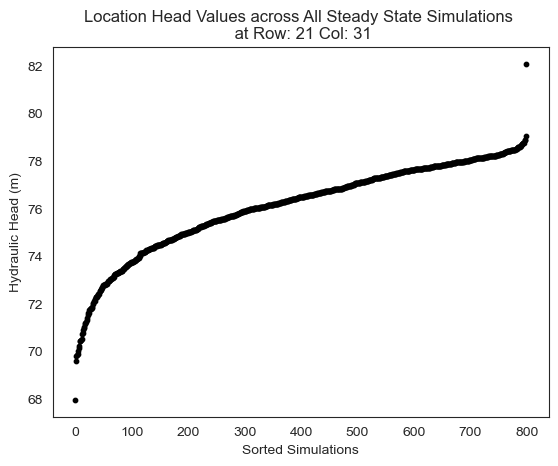

C:\Users\davem\AppData\Local\Temp\ipykernel_13844\284219430.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=30)


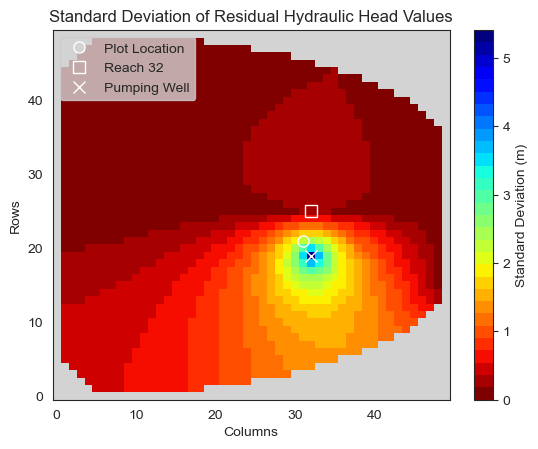

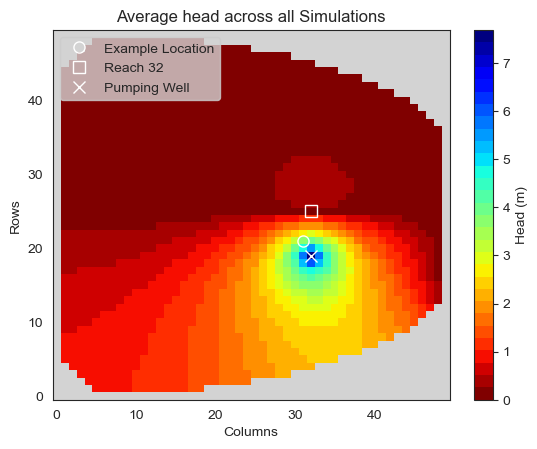

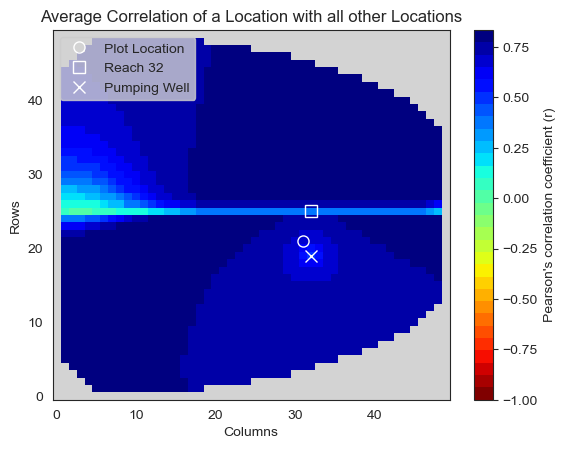

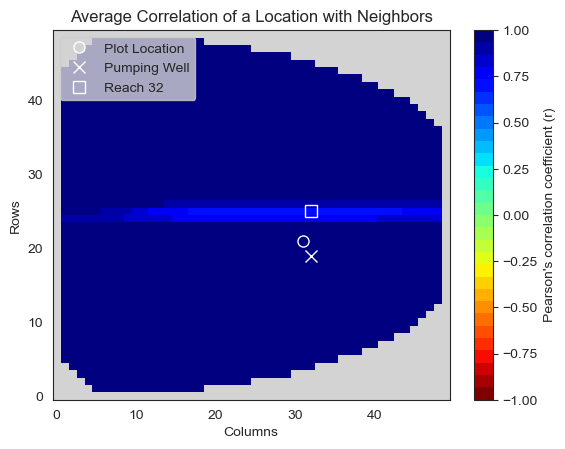

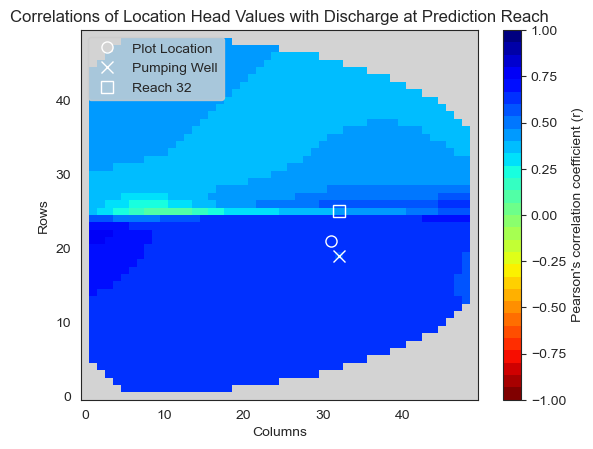

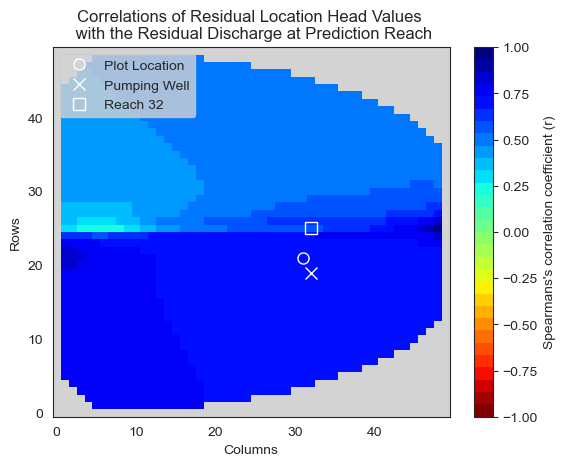

In [86]:
wn = 844
print("well num, well col, well row \n")
print(wn,int(all_well_loc[wn][0]), int(all_well_loc[wn][1]))

plt.scatter(range(len(well_head_df[wn].index)),well_head_df[wn].sort_values(), s = 10, c='k')
plt.xlabel('Sorted Simulations')
plt.ylabel('Hydraulic Head (m)')
plt.title("Location Head Values across All Steady State Simulations \n at Row: " +str(all_well_loc[wn][0])+ " Col: " + str(all_well_loc[wn][1]))
plt.show()

# wn = 1100
# print("well num, well col, well row \n")
# print(wn,int(all_well_loc[wn][0]), int(all_well_loc[wn][1]))

# plt.scatter(range(len(diff_head_df[wn].index)),diff_head_df[wn].sort_values(), s = 10, c='k')
# plt.xlabel('Sorted Simulations')
# plt.ylabel('Hydraulic Head (m)')
# plt.title("Location Head Values across All Steady State Simulations \n at Row: " +str(all_well_loc[wn][0])+ " Col: " + str(all_well_loc[wn][1]))


ztop = np.genfromtxt('base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)


kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

wellmesh = np.ndarray((50,50))
wellmesh[:][:] = -1e30

wellmesh2 = wellmesh.copy()
mesh_feat_to_target = wellmesh.copy()
spearmans_feat_to_target = wellmesh.copy()
p_value_feat_to_target = wellmesh.copy()
wellmesh_corr = wellmesh.copy()
minmesh = wellmesh.copy()


from spotpy.objectivefunctions import correlationcoefficient as r
from scipy import stats

#new_zone_q = ReachQdf.loc[well_head_noRiv.index]
#new_zone_q = ReachQdf.loc[diff_head_df.index]

#Reach number for feature to target correlation
rn = 32

#well_head_df[1060].plot()
#print(int(all_well_loc[wn, 0]),int(all_well_loc[wn, 1]))
for i in range(all_well_loc.shape[0]):
    
#     wellmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = well_head_df[i].std()    
#     rho, p = stats.spearmanr(new_zone_q[rn],well_head_df[i]) 
#     mesh_feat_to_target[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = r(new_zone_q[rn],well_head_df[i])
#     wellmesh2[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = well_head_df[i].mean() #- ztop[int(all_well_loc[i, 0]),int(all_well_loc[i, 1])]
    
   # Diff Heads
    rho, p = stats.spearmanr(new_zone_q[rn],diff_head_df[i])
    wellmesh2[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = diff_head_df[i].mean() 
    wellmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = diff_head_df[i].std()
    mesh_feat_to_target[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = r(new_zone_q[rn],diff_head_df[i])

    wellmesh_corr[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = corrmatrix[i].mean()
    minmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = corrmatrix[i].min()
    spearmans_feat_to_target[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = rho


cmap2 = cm.get_cmap("jet_r",lut=30)
cmap2.set_under("lightgray")
river = np.ndarray((48,))
river[:] = 25

#plt.figure(figsize=(8,6))

reach_label = "Reach " + str(rn)

plt.pcolormesh(KK,GG,wellmesh,cmap = cmap2, vmin = 0,shading='nearest')
plt.colorbar(label = 'Standard Deviation (m)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="w", mfc='none', linestyle = "None", label="Plot Location")
#plt.plot(range(1,49),river, color="lightblue",label='River')
plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
plt.legend(facecolor='lightgray', loc='upper left')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Standard Deviation of Residual Hydraulic Head Values')
plt.show()


#plt.figure(figsize=(8,6))

plt.pcolormesh(KK,GG,wellmesh2,cmap = cmap2,vmin=0, shading='nearest')
plt.colorbar(label = 'Head (m)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Example Location")
plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
plt.legend(facecolor='lightgray', loc='upper left')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Average head across all Simulations')
plt.show()

# plt.figure(figsize=(8,6))

plt.pcolormesh(KK,GG,wellmesh_corr,cmap = cmap2, vmin=-1,shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
plt.legend(facecolor='lightgray', loc='upper left')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Average Correlation of a Location with all other Locations')
plt.show()
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')

#plt.imshow(wellmesh, cmap='RdBu')

plt.pcolormesh(KK,GG,neighbor_corr_avg,cmap = cmap2,vmin=-1, vmax = 1, shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
plt.legend(facecolor='lightgray', loc='upper left')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Average Correlation of a Location with Neighbors')
plt.show()

plt.pcolormesh(KK,GG,mesh_feat_to_target,cmap = cmap2,vmin=-1, vmax=1, shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
plt.legend(facecolor='lightgray', loc='upper left')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Correlations of Location Head Values with Discharge at Prediction Reach')
plt.show()


plt.pcolormesh(KK,GG,spearmans_feat_to_target,cmap = cmap2,vmin=-1, vmax=1, shading='nearest')
plt.colorbar(label = 'Spearmans\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
plt.legend(facecolor='lightgray', loc='upper left')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Correlations of Residual Location Head Values \n with the Residual Discharge at Prediction Reach')
plt.show()

# plt.pcolormesh(KK,GG,p_value_feat_to_target,cmap = cmap2, shading='nearest')
# plt.colorbar(label = 'P-value From Spearmans')
# plt.plot(32,19, marker="o", markersize=8, color="k", mfc='none', linestyle = "None", label="Pumping Well")
# plt.plot(rn,25, marker="s", markersize=8, color="k", mfc='none', linestyle = "None", label=reach_label)
# plt.legend(loc='lower right')
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.title('Correlations of Location Head Values with Discharge at Prediction Reach')
# plt.show()

In [166]:
#Finding the hyperparameters

#reach number to use 
rn = 25
print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn] > 0].index) / len(new_zone_q.index)))

X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[rn], test_size=0.2,random_state = 29)

#split quality function
split_criterion = ['squared_error', 'friedman_mse']
#Number of features to consider at every split
max_features = [1.0]
# Maximum number of levels in tree
max_depth = [int(x) for x in range(4,9)] #14 was the max depth, 3 or greater is recommened, 8 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
#maximum 
maxSqrt = int(np.max(y_train)**(1/2))
max_leaf_nodes = [int(x) for x in range(50,maxSqrt,int(maxSqrt/10))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

splitter = ['best']
# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'criterion' : split_criterion,
               #'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease}
                #'splitter': splitter}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
dtr = DecisionTreeRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dtr_random = RandomizedSearchCV(estimator = dtr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=29, n_jobs = -1)
# Fit the random search model
dtr_random.fit(X_train, y_train)
best_pars_dt = dtr_random.best_params_
print(best_pars_dt)

from sklearn.tree import plot_tree


best_random = dtr_random.best_estimator_
y_pred = best_random.predict(X_test)
#well head Tree NSE

#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_test)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

# _, ax = plt.subplots(figsize=(25, 25))
# _ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

Fraction of wet simulations: 1.0
{'criterion': ['squared_error', 'friedman_mse'], 'max_depth': [4, 5, 6, 7, 8], 'min_samples_split': [2, 5, 10, 15], 'min_samples_leaf': [1, 2, 5, 10], 'max_leaf_nodes': [50, 55, None], 'min_impurity_decrease': [5, 15, 25, 35, 45]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

## Tree using Wells to predict Qout

In [37]:
#Best pars from Hyperparmeter Tuning notbook saved here as a dictionary
random_state = 29
#print(dtr_random.scorer_,dtr_random.best_score_)
#make_scorer(mean_squared_error, greater_is_better=False, squared=False) -37.21749900272201
best_pars_dt = {'splitter': 'best','max_features': 1.0,'min_samples_split': 15, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_leaf_nodes': 86, 'max_depth': 5, 'criterion': 'friedman_mse'}
#best_pars_dt = {'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 15, 'max_leaf_nodes': 56, 'max_depth': 4, 'criterion': 'friedman_mse'}#best_pars_dt = None
#best_pars_dt = {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'squared_error',  'random_state': 1}
#best_pars_dt = {'criterion' : 'absolute_error','min_impurity_decrease': 0.01}

Shape of Input Samples: (800, 2012)
Shape of Output Targets: (800,)
Total time: 1.1593265533447266


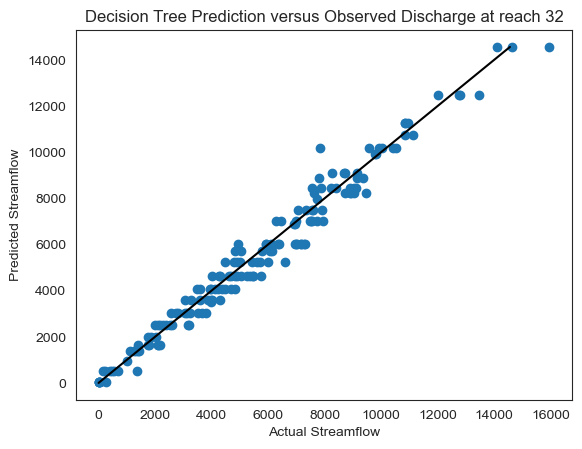

bias       -1.953900
rmse      563.868071
r           0.986489
nse         0.972086
lognse      0.960416
kge         0.974768
dtype: float64


In [62]:
# Split dataset into training set and test set, default here is 30% test
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel
from treeFuncs import metrics

t0 = time.time()
n = 1


#new_zone_q = np.log(ReachQdf.loc[well_head_noRiv.index]+1)
#new_zone_q = ReachQdf.loc[well_head_noRiv.index]

rn = 32
#imp_df, metrics_df, impurity_list, Tree, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, norm_well_df, norm_q_df[rn], None, 0.2, n, random_state)  
#imp_df, metrics_df, impurity_list, Tree, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, well_head_noRiv, new_zone_q[rn], None, 0.2, n, random_state)  

imp_df, metrics_df, impurity_list, Tree, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, well_head_noRiv, new_zone_q[rn], best_pars_dt, 0.2, n, random_state)  

print('Total time: ' + str(time.time()-t0))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Decision Tree Prediction versus Observed Discharge at reach " + str(rn)
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

print(metrics_df.mean())

     bias        rmse         r       nse    lognse       kge
0 -1.9539  563.868071  0.986489  0.972086  0.960416  0.974768


356     0.710317
32      0.148404
87      0.074892
1051    0.015514
311     0.015279
Name: 0, dtype: float64

[0.7103173248581879, 0.1484036485503433, 0.0748923895844829]


Text(0.5, 0, 'Node Number')

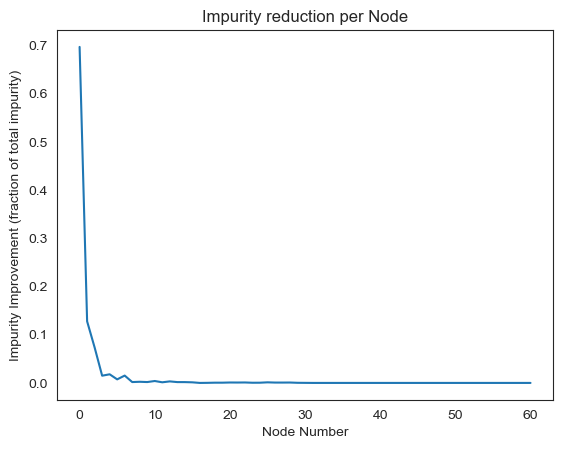

In [63]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import evalTree


print(metrics_df)
#tree.plot_tree(Tree)
treeimp = pd.DataFrame(Tree.feature_importances_, index = Tree.feature_names_in_)
#display(treeimp)
display(treeimp[0].nlargest(5))
#display(Tree.feature_names_in_[1017])
#print(Tree.feature_importances_)
#print(Tree.max_features_)
#print(Tree.n_features_in_)
print(sorted(Tree.feature_importances_, reverse=True)[:3])
from treeFuncs import quickEvalTree
imp_improv = quickEvalTree(Tree)
n_nodes = Tree.tree_.node_count
# for i in range(n_nodes):
#     print(str(i) + ': ' +str(Tree.tree_.impurity[i]))
plt.plot(imp_improv)
plt.title('Impurity reduction per Node')
plt.ylabel('Impurity Improvement (fraction of total impurity)')
plt.xlabel('Node Number')
#help(tree._tree.Tree)

In [64]:
# print(well_head_df.mean())
# norm_well_df = (well_head_df - np.min(well_head_df.min().values))
# norm_well_df = norm_well_df/ np.max(norm_well_df.max().values)
# print(np.min(norm_well_df))
#plt.scatter(range(2012),norm_well_df.var().values)
# well = '1017'
# print(Tree.feature_importances_)
# plt.scatter(well_head_df[well],ReachQdf[well])

#imp_df.sum(axis = 1).plot(kind="bar")

In [65]:
# #imp_df.to_pickle('SteadyState_DT_Impdf.pkl')


# test = pd.DataFrame(y_test)
# test['pred'] = y_pred
# test = test[test[25] > 0]
# #print(test)
# plt.scatter(test[25], test['pred'])

# print(NSE(test[25], test['pred']))
# print(kge(test[25], test['pred']))
# print(test.corrwith(test['pred']))

# plt.figure()
# plt.scatter(y_test, y_pred)
# outmax = np.max(y_pred) +10
# plt.plot([0, 1], [0, 1], color='k', linestyle='-')

# plt.xlabel("Actual Streamflow")
# plt.ylabel("Predicted Streamflow")
# title = "Decision Tree Regression for Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
# plt.title(title)
# plt.ylim((0,10))
# plt.xlim((0,10))
# # plt.yscale('log')
# # plt.xscale('log')
# #plt.legend()
# plt.show()

Shape of Input Samples: (800, 2012)
Shape of Output Targets: (800,)
Total time: 11.475913763046265
Fraction of wet simulations: 0.9825
bias        -0.843388
rmse      1017.691572
r            0.953347
nse          0.908086
lognse       0.801355
kge          0.932897
dtype: float64


Text(0.5, 1.0, 'Example Random Decision Tree Regression for Q at reach 32')

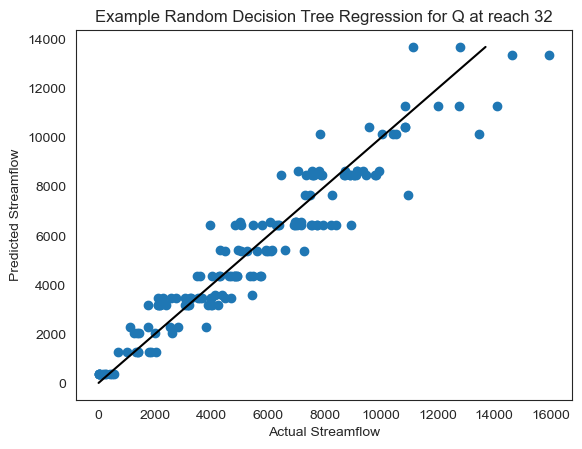

In [66]:
# RANDOM Tree 
# Split dataset into training set and test set, default here is 30% test
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel

t0 = time.time()
n = 100

#Splitter is random and max features is set to 1, note that 1.0 is all in the new Sklearn so this is a little confusing
#lastest and greatest - plus splitter setting to best
#best_pars_dt_rand = {'splitter': 'best', 'max_features': 1, 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 15, 'max_leaf_nodes': 56, 'max_depth': 4, 'criterion': 'friedman_mse'}
best_pars_dt_rand = {'splitter': 'best','max_features': 1,'min_samples_split': 15, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_leaf_nodes': 86, 'max_depth': 5, 'criterion': 'friedman_mse'}
#best_pars_dt_rand = {'max_features': 1, 'max_depth': 7, 'criterion': 'absolute_error', 'min_impurity_decrease': 0.01}
#best_pars_dt_rand = {'splitter': 'best', 'max_features': 1}

#imp_df_rand, metrics_df_rand, rand_impurity_list, randTree, y_test, y_pred = trainAndEvaluateModel(ExtraTreeRegressor, norm_well_df, norm_q_df[rn], best_pars_dt_rand, 0.2, n, random_state)  

imp_df_rand, metrics_df_rand, rand_impurity_list, randTree, y_test, y_pred = trainAndEvaluateModel(ExtraTreeRegressor, well_head_noRiv, new_zone_q[rn], best_pars_dt_rand, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_rand.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Example Random Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)

C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2.set_under("k")
C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2.set_under("k")


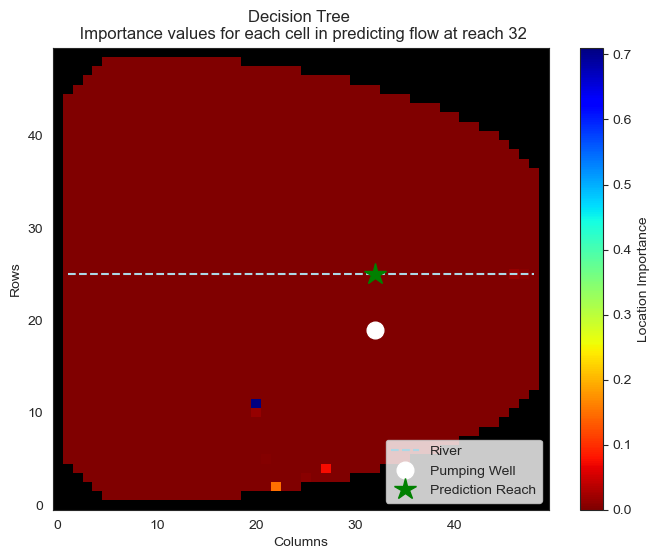

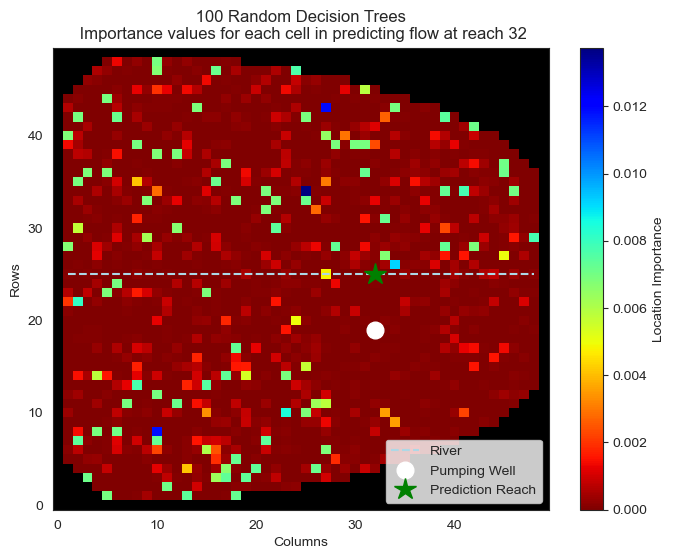

In [79]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1
n = 100

title = 'Decision Tree \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_df = plotImportance(imp_df,well_head_noRiv, well_loc_df,numTS,1,rn,title)

title_rand = ' 100 Random Decision Trees \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_rand = plotImportance(imp_df_rand,well_head_noRiv, well_loc_df,numTS,n,rn,title_rand)


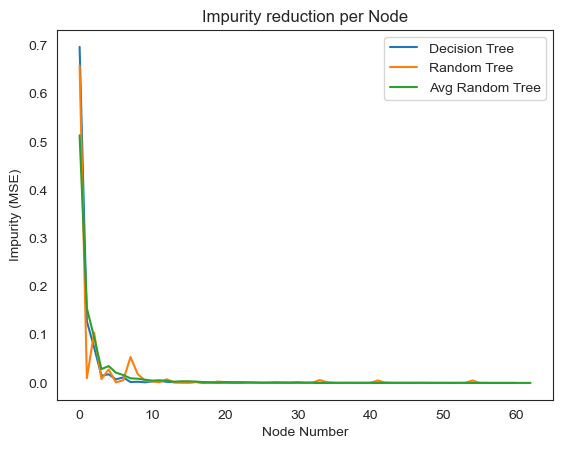

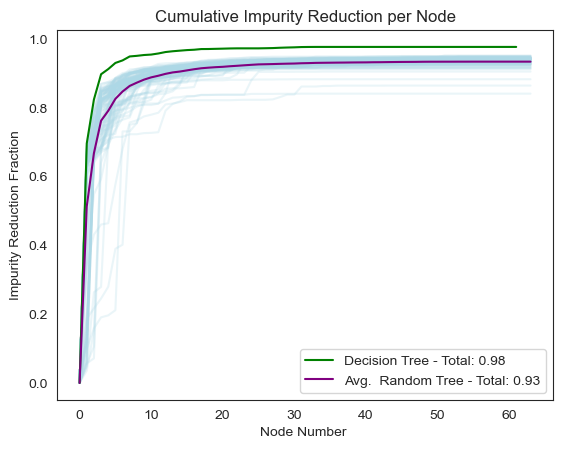

In [42]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import evalTree

impurity_df = pd.DataFrame(rand_impurity_list).fillna(0)
avg_rand_impurity = impurity_df.mean(axis = 0)

max_rand_idx = impurity_df.iloc[:,:2].sum(axis=1).idxmax()
#print(max_rand_idx)
#print(impurity_df)
max_rand_impurity = impurity_df.loc[max_rand_idx]

min_rand_idx = impurity_df.sum(axis = 1).idxmin()
min_rand_idx = impurity_df[0].idxmin()

min_rand_impurity = impurity_df.loc[min_rand_idx]
#display(impurity_df)
#print(Tree.max_features_)
#print(Tree.n_features_in_)
#print(sorted(randTree.feature_importances_, reverse=True)[:3])
#from treeFuncs import evalTree
rand_imp_improv = quickEvalTree(randTree)

plt.plot(imp_improv, label = "Decision Tree")
plt.plot(rand_imp_improv, label ="Random Tree")
plt.plot(avg_rand_impurity, label ="Avg Random Tree")
plt.title('Impurity reduction per Node')
plt.ylabel('Impurity (MSE)')
plt.xlabel('Node Number')
plt.legend()
#help(tree._tree.Tree)
plt.show()

#quick cumulative function that inserts 0 at beginning 
def cumImpurity(imp):
    nodes = 100
    return np.cumsum(np.insert(imp,0,0))[:nodes] #inserting 0 at the beginning - essentially to indicate the original impurity reduction (0)



dt_impurity_cumulative = cumImpurity(imp_improv)
#rand_impurity_cumulative = cumImpurity(rand_imp_improv)[:50]
avgrand_impurity_cumulative = cumImpurity(avg_rand_impurity.to_numpy())
maxrand_impurity_cumulative = cumImpurity(max_rand_impurity.to_numpy())
minrand_impurity_cumulative = cumImpurity(min_rand_impurity.to_numpy())
x_nodes = np.arange(len(minrand_impurity_cumulative))
          
for i in range(n):
    single_impurity = cumImpurity(impurity_df.loc[i].to_numpy())
    plt.plot(single_impurity, color='lightblue', alpha = 0.25)
    
plt.plot(dt_impurity_cumulative, markersize = 4, color='g', label = "Decision Tree - Total: {:.2f}".format(np.max(dt_impurity_cumulative)))
#plt.plot(rand_impurity_cumulative, markersize = 4, marker= 'o', label ="Random Tree - Total: {:.2f}".format(np.max(rand_impurity_cumulative)))
plt.plot(avgrand_impurity_cumulative, markersize = 4, color='purple', label ="Avg.  Random Tree - Total: {:.2f}".format(np.max(avgrand_impurity_cumulative)))
#plt.fill_between(x_nodes,maxrand_impurity_cumulative, minrand_impurity_cumulative, alpha = 0.2, label ="Min and Max Random Tree")
#plt.plot(maxrand_impurity_cumulative, markersize = 4,marker='.', label ="Max  Random Tree - Total: {:.2f}".format(np.max(avgrand_impurity_cumulative)))
    
plt.title('Cumulative Impurity Reduction per Node')
plt.ylabel('Impurity Reduction Fraction')
plt.xlabel('Node Number ')
plt.xticks(minor=True)
plt.legend()

## Gradient Boosting

In [54]:
#print(xgr_random.scorer_,xgr_random.best_score_)

best_pars_gr = {'subsample': 0.6, 'n_estimators': 175, 'min_samples_split': 15, 'min_samples_leaf': 1, 'min_impurity_decrease': 25, 'max_leaf_nodes': 86, 'max_depth': 4, 'loss': 'huber', 'learning_rate': 0.1, 'criterion': 'friedman_mse'}
#old pars
#best_pars_gr = {'subsample':1.0, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 45, 'max_leaf_nodes': 52, 'max_features': 1.0, 'max_depth': 3, 'loss': 'squared_error','learning_rate': 0.1, 'criterion': 'friedman_mse', 'random_state':3}

#best_pars_gr = {'subsample': 0.6, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 45, 'max_leaf_nodes': 52, 'max_features': 1.0, 'max_depth': 3, 'loss': 'squared_error', 'criterion': 'friedman_mse'}

Shape of Input Samples: (800, 2012)
Shape of Output Targets: (800,)
Total time: 184.08332514762878


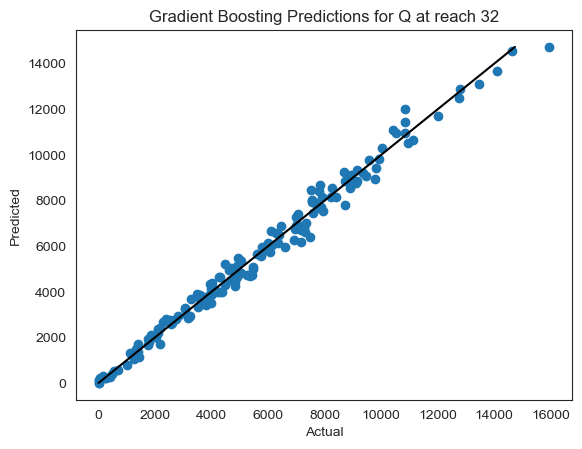

       bias        rmse         r       nse    lognse       kge
0 -0.398695  380.889706  0.993639  0.987263  0.971046  0.987692


In [68]:
# Split dataset into training set and test set, default here is 30% test
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel

t0 = time.time()
n = 1

gr_imp_df, metrics_df_gr, impurity_gr, Tree, y_test, y_pred = trainAndEvaluateModel(GradientBoostingRegressor, well_head_noRiv, new_zone_q[rn], best_pars_gr, 0.2, n, random_state)  


t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Gradient Boosting Predictions for Q at reach " + str(rn)
plt.title(title)

plt.show()
print(metrics_df_gr)

[84]


,0,1
84,4,24


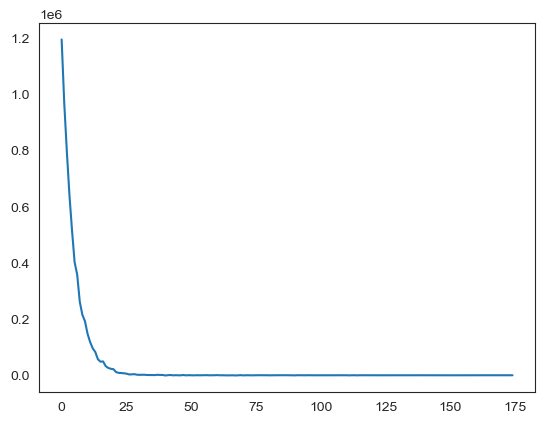

In [56]:
#display(gr_imp_df)
MostImp = []
for i in range(n):
    MostImp.append(int(gr_imp_df[i].idxmax()))

countlist = [MostImp.count(i) for i in MostImp]
print(MostImp)
#print(countlist)
display(well_loc_df.loc[MostImp])

oob_improvement = Tree.oob_improvement_

plt.plot(oob_improvement)

C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2.set_under("k")


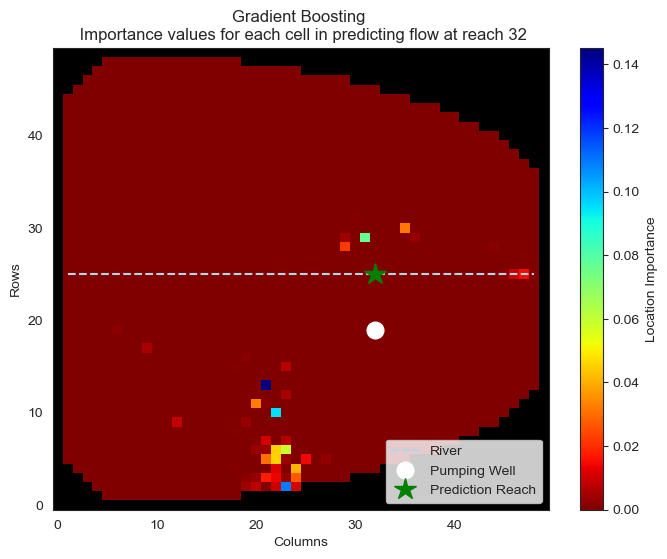

In [78]:
n=1
title_gr = 'Gradient Boosting \n Importance values for each cell in predicting flow at reach ' + str(rn)
wellmesh_gr = plotImportance(gr_imp_df,well_head_noRiv, well_loc_df,1,n,rn,title_gr)

## Random Forest - Steady State

In [58]:
#new best RF
best_pars_rf = {'n_estimators': 225, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 25, 'max_samples': 0.9, 'max_leaf_nodes': None, 'max_depth': 7, 'criterion': 'friedman_mse'}
#best_pars_rf = {'n_estimators': 175, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 5, 'max_samples': 0.3, 'max_leaf_nodes': None, 'max_depth': 7, 'criterion': 'friedman_mse'}
#best_pars_rf = {'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}
#best_pars_rf = {'max_depth': 4, 'criterion' : 'absolute_error','min_impurity_decrease': 0.01}


In [ ]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1
rn = 32
    
rf_imp_df, metrics_df_rf, impurity_list, Tree, y_test, y_pred = trainAndEvaluateModel(RandomForestRegressor, well_head_noRiv, new_zone_q[rn], best_pars_rf, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred)
outmin = np.min(y_pred)

plt.plot([outmin, outmax], [outmin, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Random Forest Regression for predicting Q at reach " + str(rn) 
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()
print(metrics_df_rf)

Shape of Input Samples: (750, 2012)
Shape of Output Targets: (750,)


In [25]:
#display(rf_imp_df)
MostImp = []
for i in range(n):
    MostImp.append(int(rf_imp_df[i].idxmax()))

countlist = [MostImp.count(i) for i in MostImp]
print(MostImp)
print(countlist)
display(well_loc_df.loc[MostImp])

[32]
[1]


,0,1
32,2,22


C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2.set_under("k")


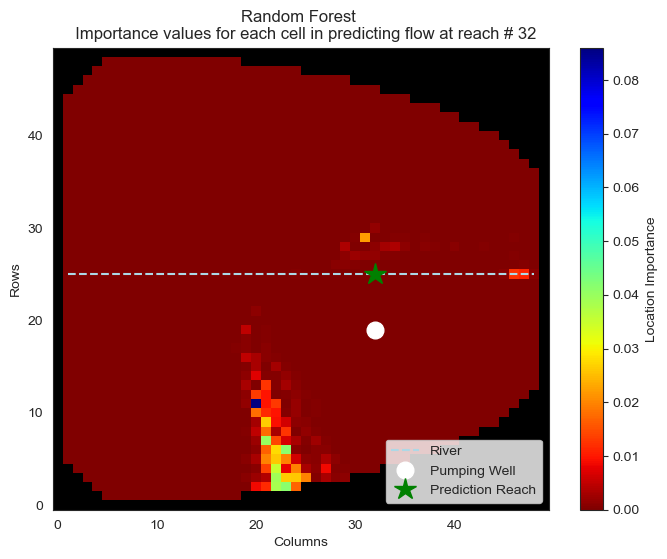

In [77]:
title_rf = 'Random Forest \n  Importance values for each cell in predicting flow at reach # ' + str(rn)
wellmesh_rf = plotImportance(rf_imp_df,well_head_noRiv, well_loc_df,numTS,1,rn,title_rf)
#plt.plot(20, 25, marker="*", markersize=16, color="Green", linestyle = "None",label="Prediction Reach")

# wellmesh_rf_32 = plotImportance(rf_imp_df_32,well_head_noRiv, well_loc_df,numTS,1,rn,title_rf)
# wellmesh_rf_37 = plotImportance(rf_imp_df_37,well_head_noRiv, well_loc_df,numTS,1,rn,title_rf)
#title_rf = 'Random Forest \n  Importance values for each cell in predicting flow at reach ' + str(20)
#wellmesh_rf_20 = plotImportance(rf_imp_df_37,well_head_noRiv, well_loc_df,numTS,1,20,title_rf)


### Testing the parameters as features
Using a single decision tree and the reach 32 out flow

Shape of Input Samples: (800, 8)
Shape of Output Targets: (800,)
Total time: 0.040883779525756836
Fraction of wet simulations: 0.9825
bias         2.634162
rmse      1053.053528
r            0.951118
nse          0.902642
lognse       0.597767
kge          0.931457
dtype: float64


Text(0.5, 1.0, 'Example Random Decision Tree Regression for Q at reach 32')

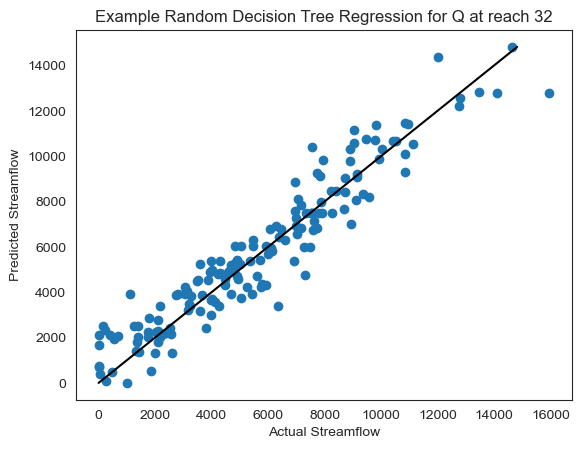

In [47]:
t0 = time.time()
n = 1
pars = X.loc[well_head_noRiv.index]
imp_df_pars, metrics_df_pars, pars_impurity_list, parsTree, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, pars, new_zone_q[rn],None, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_pars.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Example Random Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)

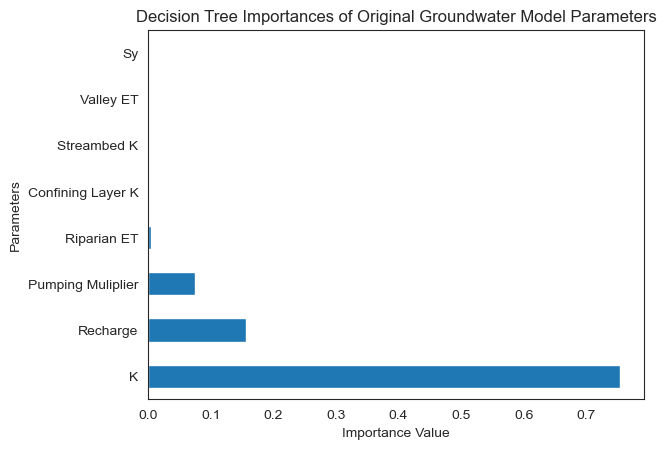

In [53]:
plot_par_names = ['K', 'Confining Layer K', 'Sy', 'Recharge', 'Valley ET', 'Riparian ET', 'Streambed K','Pumping Muliplier']
feat_importances = pd.Series(parsTree.feature_importances_, index=plot_par_names)
feat_importances.nlargest(10).plot(kind='barh',)
plt.xlabel('Importance Value')
plt.ylabel('Parameters')
plt.title('Decision Tree Importances of Original Groundwater Model Parameters')
plt.show()

In [ ]:
#set up the meshgrid   
kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)


river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")
wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
for k in range(len(all_well_loc)):
        wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

cmap_rf = mp.colormaps.get_cmap("Greens")
wellmesh_rf_masked = np.ma.masked_array(wellmesh_rf, wellmesh_rf < 0.001)

cmap_gr = mp.colormaps.get_cmap("Purples")
wellmesh_gr_masked = np.ma.masked_array(wellmesh_rf_32, wellmesh_rf_32 < 0.001)

cmap_dt = mp.colormaps.get_cmap("Blues")
wellmesh_dt_masked = np.ma.masked_array(wellmesh_rf_37, wellmesh_rf_37 < 0.001)

cmap_rand = mp.colormaps.get_cmap("Reds")
wellmesh_rand_masked = np.ma.masked_array(wellmesh_rf_20, wellmesh_rf_20 < 0.01)

# combine them and build a new colormap
colors = np.vstack((cmap_rf(np.linspace(0.,1,128)), cmap_gr(np.linspace(0.,1,128)), cmap_dt(np.linspace(0.,1,128)),cmap_rand(np.linspace(0.,1,128))))
print(colors)
vmin= 0.001
vmax= 0.05
mymap = mp.colors.LinearSegmentedColormap.from_list('Merged',colors)
fig, axs = plt.subplots(figsize=(10,12))
#plt.figure(figsize=(8,10))
alpha = 0.6
axs.pcolormesh(KK,GG,wellmesh_bd,vmax = vmax, vmin = vmin, cmap = cmap_bd, shading='nearest', alpha = 0.05)
axs.pcolormesh(KK,GG,wellmesh_rand_masked,vmax = vmax, vmin = vmin, cmap = cmap_rand, shading='nearest', alpha = alpha)
axs.pcolormesh(KK,GG,wellmesh_dt_masked,vmax = vmax, vmin = vmin, cmap = cmap_dt, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Decision Tree", shrink = 0.25, pad = 0.05, anchor = (0,0.25), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rf_masked,vmax = vmax, vmin = vmin, cmap = cmap_rf, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Random Forest", shrink = 0.25, anchor = (0.3,0.75), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_gr_masked,vmax = vmax, vmin = vmin, cmap = cmap_gr, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Gradient Boosted", shrink = 0.25, anchor = (0.75,1), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rand_masked,vmax = vmax, vmin = vmin, cmap = cmap_rand, shading='nearest', alpha = alpha)

#plt.colorbar(cmap = mymap, location = 'bottom')


axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
axs.plot(25, 25, marker="*", markersize=10, color="Green", linestyle = "None",label="Prediction Reach")
axs.plot(32, 25, marker="*", markersize=10, color="Purple", linestyle = "None",label="Prediction Reach")
axs.plot(37, 25, marker="*", markersize=10, color="Blue", linestyle = "None",label="Prediction Reach")
axs.plot(20, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")

axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Random Forest Importance values for each cell in predicting flow at reach ' + str(rn) + ' for 3 different target reaches ')
axs.legend(loc="lower right")
#axs[1].axis('off')
cbar = fig.colorbar(mp.cm.ScalarMappable(cmap=mymap), drawedges = False, ax = axs,label = 'Importance Gradients (darker = more important)', orientation = 'horizontal', ticks = [0,0.1,0.35,0.6,0.85,1],pad = 0.1, shrink = 0.75)
cbar.ax.set_xticklabels(['','Reach 20','Reach 25', 'Reach 32','Reach 37',''])
#plt.legend()

### Trying the Iterative random Forest 

https://github.com/Yu-Group/iterative-Random-Forest/blob/master/demo/03_iRF_demo_Regression.ipynb

In [ ]:
#print(all_well_loc)


## Extra plotting code cells

In [ ]:
kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)


wellmesh_ztop = np.ndarray((50,50))
wellmesh_ztop[:,:] = 0

for k in range(len(all_well_loc)):
    wellmesh_ztop[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = ztop[int(all_well_loc[k, 0]),int(all_well_loc[k, 1])]
wellmesh_ztop = np.ma.masked_array(wellmesh_ztop, wellmesh_ztop < 0.01)
river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")

cmap_ch = cm.get_cmap("Paired")#,lut=20)
cmap_ch.set_under("w")
#cmap_ch.set_over("k")

wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
wm_ch = wellmesh_bd.copy()

CHBound_loc = np.where(all_well_loc[:,1] == 48) 
rch_bound = np.where(all_well_loc[:,1] < 10) 
et_bound = np.where(all_well_loc[:,1] >= 10)
#print(CHBound_loc)

for k in range(len(all_well_loc)):
    wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

for j in rch_bound[0]:
    wm_ch[int(all_well_loc[j, 1]), int(all_well_loc[j, 0])] = 3
for j in et_bound[0]:
    wm_ch[int(all_well_loc[j, 1]), int(all_well_loc[j, 0])] = 4     
for j in CHBound_loc[0]:
    wm_ch[int(all_well_loc[j, 1]), int(all_well_loc[j, 0])] = 2
wm_ch = np.ma.masked_array(wm_ch, wm_ch < 0.01)

    
fig, axs = plt.subplots(figsize=(8,8))
#plt.figure(figsize=(8,10))
alpha = 0.6
#axs.pcolormesh(KK,GG,wellmesh_bd, cmap = cmap_bd, shading='nearest', alpha = 0.05, ec='grey')
axs.pcolormesh(KK,GG,wellmesh_ztop, cmap = cm.terrain, shading='nearest', alpha = 0.5, ec='None')

#axs.pcolormesh(KK,GG,wm_ch, cmap = cmap_ch, shading='nearest', alpha = 0.5)

axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
#axs.plot(rn, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")
axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Model Domain Overview')
axs.legend(loc="lower right")
plt.colorbar()

In [ ]:

    
axes = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
axes.set_box_aspect([1,1,0.35])
axes.plot_surface(GG, KK, wellmesh_ztop, cmap = cm.terrain, edgecolor='None')
axes.set_title('Model Domain - Top Surface Elevations')
axes.set_xlabel('Columns (km)')
axes.set_ylabel('Rows (km)')
axes.set_zlabel('Elevation (m)')


axes.view_init(45, -50,0)
plt.savefig(r'C:\Users\davem\Documents\Thesis\Topsurface.png')